[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/benjaminlarkey/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


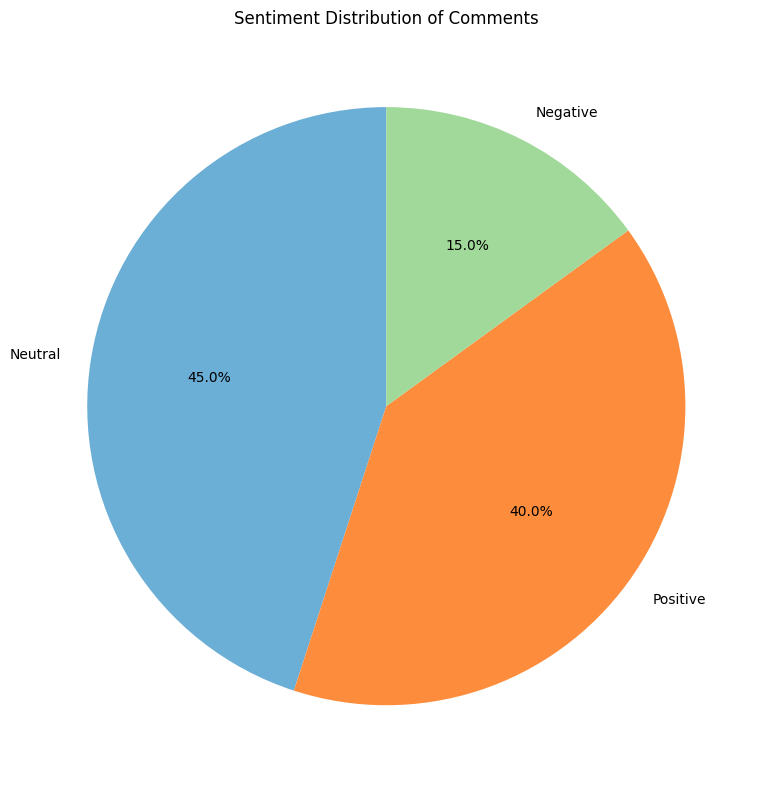

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
from datetime import datetime

# vader
nltk.download('vader_lexicon')

# init vader lex
sia = SentimentIntensityAnalyzer()

# function to convert date to unix
def date_to_unix(date_str, date_format="%Y-%m-%d %H:%M:%S"):
    dt = datetime.strptime(date_str, date_format)
    return dt.timestamp()

# load the data
file_path = 'data/snow.csv'  # Stock data being analyzed
stock_data = pd.read_csv(file_path)

example_date = "2024-11-18 23:00:00"
unix_time = date_to_unix(example_date)

# cutoff for comments
cutoff_time = unix_time

# filter comments
stock_data = stock_data[stock_data['created_utc'] < cutoff_time]

# print(stock_data.head(20))

# function to analyze using vader
def analyze_sentiment_vader(comment):
    sentiment = sia.polarity_scores(comment)
    compound_score = sentiment['compound']
    if compound_score > 0.05:
        return "Positive"
    elif compound_score < -0.05:
        return "Negative"
    else:
        return "Neutral"

# apply vader sentiment to each comment
stock_data['sentiment'] = stock_data['comment'].apply(lambda x: analyze_sentiment_vader(str(x)))

# see a sample of comments
# print(stock_data[['comment', 'sentiment']].head(20))

# sentiment counts
sentiment_counts = stock_data['sentiment'].value_counts()

# generate a pie chart
plt.figure(figsize=(8, 8))
sentiment_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, labels=sentiment_counts.index, colors=['#6baed6', '#fd8d3c', '#a1d99b'])
plt.title("Sentiment Distribution of Comments")
plt.ylabel("")
plt.tight_layout()
plt.show()
